In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# for visualisation
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pylab as pylab
from matplotlib import cm
import seaborn as sns
# theme
plt.style.use(['seaborn-whitegrid'])
plt.rcParams["figure.figsize"] = (16, 5)

# colab gpu verification
import tensorflow as tf
tf.test.gpu_device_name()

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3402652269309035371, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11727023930906180765
 physical_device_desc: "device: XLA_CPU device"]

In [0]:
#from google.colab import files
#uploaded = files.upload()

Saving steam20190101-20200318_ver3.csv to steam20190101-20200318_ver3.csv


In [0]:
# 불러오기
temperature = pd.read_csv('steam20190101-20200318_ver3.csv')
# 필요없는 컬럼 지우기(각자 분석 환경에 맞춰서 주석처리 되어 있는 것들 해제하고 사용)
del temperature['datetime']
del temperature['date']
del temperature['time']
del temperature['date(map)']
del temperature['time(map)']
#del temeperature['datetimemap'] <- 분석 결과 매핑할 때 필요하니 웬만하면 없애지 말고 없애러면 조인할 수 있게 따로 저장해두기
# datetime(map) 컬럼 명 바꾸기
temperature.rename(columns={'datetime(map)':'datetimemap'}, inplace = True)
# datetime이라는 이름의 컬럼 새로 만들기
temperature['datetime'] = pd.date_range(start='1/1/2019 00:00:00', periods=len(temperature), freq='H')
# datetime 컬럼 인덱스 지정(필요시)
temperature.set_index('datetime', inplace=True)
# 결측치 제거
temperature.dropna(axis=0, inplace=True)

In [0]:
temp = temperature

In [0]:
del temp['datetimemap']

In [0]:
temp

,temperature
datetime,
2019-01-01 00:00:00,-4.0
2019-01-01 01:00:00,-2.0
2019-01-01 02:00:00,-2.0
2019-01-01 03:00:00,-1.6
2019-01-01 04:00:00,-1.0
...,...
2020-03-17 19:00:00,10.1
2020-03-17 20:00:00,9.6
2020-03-17 21:00:00,8.4


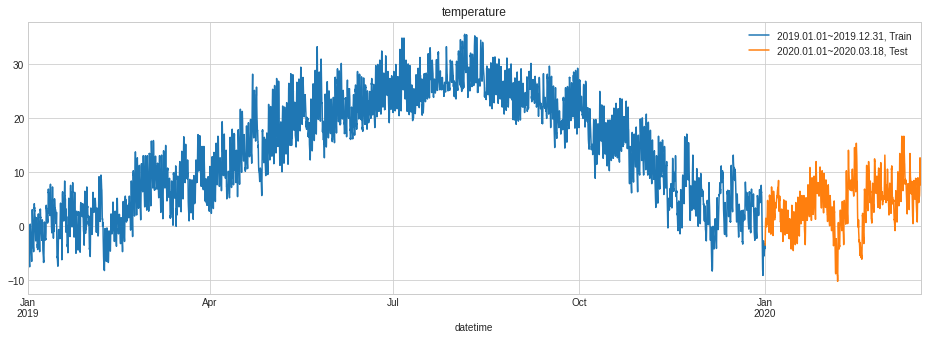

In [0]:
temp["temperature"][:'2019'].plot(legend=True)
temp["temperature"]['2020':].plot(legend=True)
plt.legend(['2019.01.01~2019.12.31, Train','2020.01.01~2020.03.18, Test'])
plt.title('temperature')
plt.show()

In [0]:
print(temp["temperature"][:'2019'])
print('-'*25)
print(temp["temperature"]['2020':])

datetime
2019-01-01 00:00:00   -4.0
2019-01-01 01:00:00   -2.0
2019-01-01 02:00:00   -2.0
2019-01-01 03:00:00   -1.6
2019-01-01 04:00:00   -1.0
                      ... 
2019-12-31 19:00:00   -3.9
2019-12-31 20:00:00   -3.2
2019-12-31 21:00:00   -4.0
2019-12-31 22:00:00   -3.8
2019-12-31 23:00:00   -4.1
Name: temperature, Length: 8760, dtype: float64
-------------------------
datetime
2020-01-01 00:00:00    -3.5
2020-01-01 01:00:00    -2.4
2020-01-01 02:00:00    -1.3
2020-01-01 03:00:00    -0.6
2020-01-01 04:00:00     0.1
                       ... 
2020-03-17 19:00:00    10.1
2020-03-17 20:00:00     9.6
2020-03-17 21:00:00     8.4
2020-03-17 22:00:00     8.2
2020-03-17 23:00:00     7.7
Name: temperature, Length: 1848, dtype: float64


In [0]:
temp_train = temp[:'2019'].iloc[:, 0:1].values
temp_test = temp['2020':].iloc[:, 0:1].values

In [0]:
print('temp_train.shape:', temp_train.shape)
print('-'*25)
print('temp_test.shape:', temp_test.shape)

temp_train.shape: (8760, 1)
-------------------------
temp_test.shape: (1848, 1)


In [0]:
step_size = 24
X_train = []
y_train = []

In [0]:
sc = MinMaxScaler(feature_range=(0, 1))
temp_train_scaled = sc.fit_transform(temp_train)

In [0]:
for i in range(step_size, 8760):
    X_train.append(temp_train_scaled[i-step_size:i, 0])
    y_train.append(temp_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
temp_concat = pd.concat((temp["temperature"][:'2019'], temp["temperature"]['2020':]), axis=0)
inputs = temp_concat[len(temp_concat)-len(temp_test)-step_size:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
print('inputs.shape:', inputs.shape)

inputs.shape: (1872, 1)


In [0]:
for i in range(step_size, temp_test.shape[0]+step_size):
    X_test.append(inputs[i-step_size:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
print('X_train.shape:', X_train.shape)
print('-'*25)
print('y_train.shape:', y_train.shape)
print('-'*25)
print('X_test.shape:', X_test.shape)

X_train.shape: (8736, 24, 1)
-------------------------
y_train.shape: (8736,)
-------------------------
X_test.shape: (1848, 24, 1)


In [0]:
def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(rmse)#("simpleRNN RMSE is {}.".format(rmse))

input_shape = (step_size, 1)
epochs = 200
batch_size = 256
metrics = ['mse', RMSE, R2]
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

In [0]:
rnn = Sequential()

rnn.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
rnn.add(Dropout(0.2))

rnn.add(SimpleRNN(100))
rnn.add(Dropout(0.2))

rnn.add(Dense(1))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 24, 50)            2600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               15100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn.compile(optimizer='adam', loss='mse', metrics=metrics)

In [0]:
history_RNN = rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], shuffle=False)




Epoch 1/200





8736/8736 [==============================] - 2s 269us/step - loss: 0.0998 - mean_squared_error: 0.0998 - RMSE: 0.2976 - R2: -17.8079
Epoch 2/200
8736/8736 [==============================] - 1s 166us/step - loss: 0.0222 - mean_squared_error: 0.0222 - RMSE: 0.1462 - R2: -3.3714
Epoch 3/200
8736/8736 [==============================] - 1s 162us/step - loss: 0.0145 - mean_squared_error: 0.0145 - RMSE: 0.1176 - R2: -1.9152
Epoch 4/200
8736/8736 [==============================] - 1s 167us/step - loss: 0.0108 - mean_squared_error: 0.0108 - RMSE: 0.1017 - R2: -1.1657
Epoch 5/200
8736/8736 [==============================] - 1s 166us/step - loss: 0.0094 - mean_squared_error: 0.0094 - RMSE: 0.0947 - R2: -0.8709
Epoch 6/200
8736/8736 [==============================] - 1s 166us/step - loss: 0.0082 - mean_squared_error: 0.0082 - RMSE: 0.0885 - R2: -0.6161
Epoch 7/200
8736/8736 [==============================] - 1s 165us/step - loss: 0.0081 - mean_squared_error: 0.0081 - RMSE: 0.08

In [0]:
predicted_RNN = rnn.predict(X_test)
predicted_RNN = sc.inverse_transform(predicted_RNN)

In [0]:
rnn.evaluate(X_train, y_train)

8736/8736 [==============================] - 1s 148us/step


[0.004434927037976565,
 0.004434927037976565,
 0.05880197352685389,
 -1.141095900055253]

In [0]:
simpleRNN_RMSE = return_rmse(temp_test, predicted_RNN)
simpleRNN_RMSE

1.623610652424792


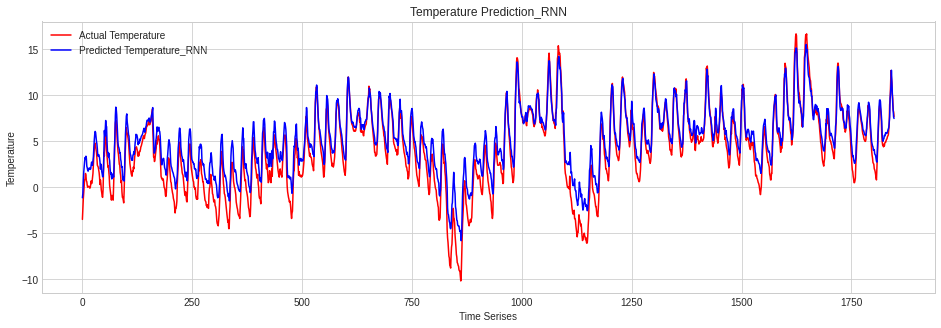

In [0]:
plt.plot(temp_test, color='red', label='Actual Temperature')
plt.plot(predicted_RNN, color='blue', label='Predicted Temperature_RNN')
plt.title('Temperature Prediction_RNN')
plt.xlabel('Time Serises')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [0]:
lstm = Sequential()

lstm.add(LSTM(50, return_sequences=True, input_shape=input_shape))
lstm.add(Dropout(0.2))

lstm.add(LSTM(100))
lstm.add(Dropout(0.2))

lstm.add(Dense(1))

In [0]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm.compile(optimizer='adam', loss='mse', metrics=metrics)

In [0]:
history_LSTM = lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
8736/8736 [==============================] - 6s 740us/step - loss: 0.0123 - mean_squared_error: 0.0123 - RMSE: 0.1060 - R2: -1.2671
Epoch 2/200
8736/8736 [==============================] - 5s 581us/step - loss: 0.0113 - mean_squared_error: 0.0113 - RMSE: 0.1032 - R2: -1.0333
Epoch 3/200
8736/8736 [==============================] - 5s 582us/step - loss: 0.0159 - mean_squared_error: 0.0159 - RMSE: 0.1172 - R2: -1.6941
Epoch 4/200
8736/8736 [==============================] - 5s 586us/step - loss: 0.0135 - mean_squared_error: 0.0135 - RMSE: 0.1082 - R2: -1.3302
Epoch 5/200
8736/8736 [==============================] - 5s 579us/step - loss: 0.0161 - mean_squared_error: 0.0161 - RMSE: 0.1177 - R2: -1.8226
Epoch 6/200
8736/8736 [==============================] - 5s 581us/step - loss: 0.0253 - mean_squared_error: 0.0253 - RMSE: 0.1464 - R2: -3.3972
Epoch 7/200
8736/8736 [===================

In [0]:
predicted_LSTM = lstm.predict(X_test)
predicted_LSTM = sc.inverse_transform(predicted_LSTM)

In [0]:
lstm.evaluate(X_train, y_train)

8736/8736 [==============================] - 3s 311us/step


[0.0009441713353379326,
 0.0009441713353379326,
 0.026731509534512466,
 0.5583517721721104]

In [0]:
LSTM_RMSE = return_rmse(temp_test, predicted_LSTM)
LSTM_RMSE

0.6069032122464924


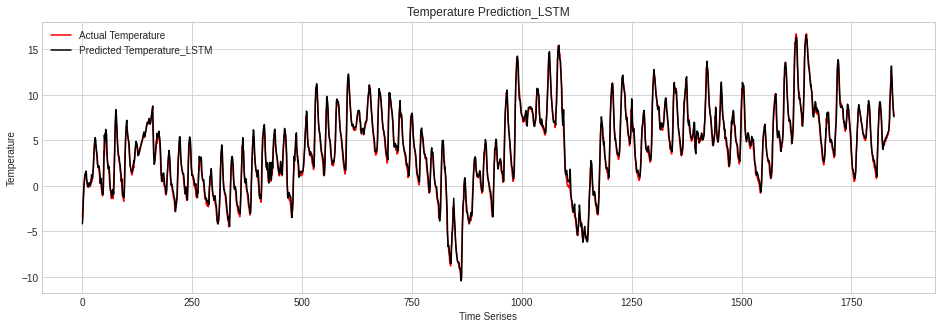

In [0]:
plt.plot(temp_test, color='red', label='Actual Temperature')
plt.plot(predicted_LSTM, color='black', label='Predicted Temperature_LSTM')
plt.title('Temperature Prediction_LSTM')
plt.xlabel('Time Serises')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [0]:
gru = Sequential()

gru.add(GRU(50, return_sequences=True, input_shape=input_shape, activation='tanh'))
gru.add(Dropout(0.2))

gru.add(GRU(100, activation='tanh'))
gru.add(Dropout(0.2))

gru.add(Dense(1))

In [0]:
gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 50)            7800      
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               45300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 53,201
Trainable params: 53,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
gru.compile(optimizer='adam', loss='mse', metrics=metrics)

In [0]:
history_GRU = gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], shuffle=False)

Epoch 1/200
8736/8736 [==============================] - 5s 626us/step - loss: 0.0109 - mean_squared_error: 0.0109 - RMSE: 0.0978 - R2: -1.0436
Epoch 2/200
8736/8736 [==============================] - 4s 451us/step - loss: 0.0067 - mean_squared_error: 0.0067 - RMSE: 0.0796 - R2: -0.2482
Epoch 3/200
8736/8736 [==============================] - 4s 452us/step - loss: 0.0069 - mean_squared_error: 0.0069 - RMSE: 0.0802 - R2: -0.2608
Epoch 4/200
8736/8736 [==============================] - 4s 457us/step - loss: 0.0065 - mean_squared_error: 0.0065 - RMSE: 0.0779 - R2: -0.1910
Epoch 5/200
8736/8736 [==============================] - 4s 455us/step - loss: 0.0058 - mean_squared_error: 0.0058 - RMSE: 0.0735 - R2: -0.0693
Epoch 6/200
8736/8736 [==============================] - 4s 456us/step - loss: 0.0048 - mean_squared_error: 0.0048 - RMSE: 0.0676 - R2: 0.0891
Epoch 7/200
8736/8736 [==============================] - 4s 457us/step - loss: 0.0042 - mean_squared_error: 0.0042 - RMSE: 0.0633 - R2: 0

In [0]:
predicted_GRU = gru.predict(X_test)
predicted_GRU = sc.inverse_transform(predicted_GRU)

In [0]:
gru.evaluate(X_train, y_train)

8736/8736 [==============================] - 3s 288us/step


[0.0012695149586858159,
 0.0012695149586858159,
 0.029713042711518405,
 0.36095529401695337]

In [0]:
GRU_RMSE = return_rmse(temp_test, predicted_GRU)
GRU_RMSE

0.5863855199312641


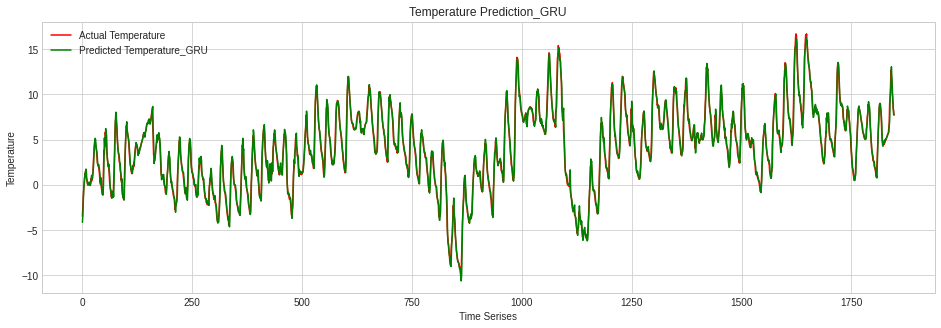

In [0]:
plt.plot(temp_test, color='red', label='Actual Temperature')
plt.plot(predicted_GRU, color='green', label='Predicted Temperature_GRU')
plt.title('Temperature Prediction_GRU')
plt.xlabel('Time Serises')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [0]:
print('simpleRNN RMSE:', '1.623610652424792')
print('LSTM RMSE:', '0.6069032122464924')
print('GRU RMSE:', '0.5863855199312641')

simpleRNN RMSE: 1.623610652424792
LSTM RMSE: 0.6069032122464924
GRU RMSE: 0.5863855199312641


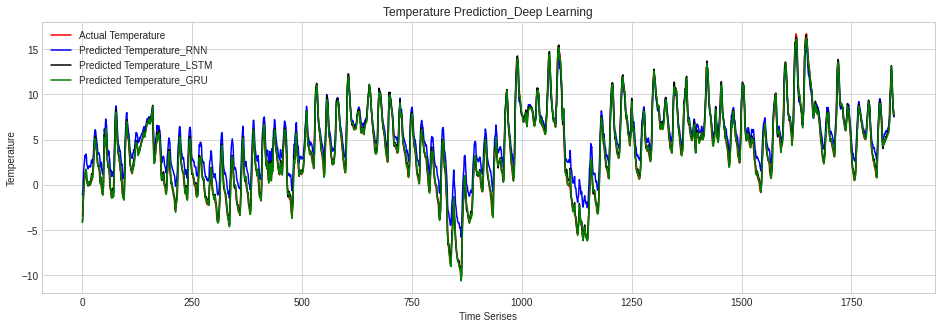

In [0]:
plt.plot(temp_test, color='red', label='Actual Temperature')
plt.plot(predicted_RNN, color='blue', label='Predicted Temperature_RNN')
plt.plot(predicted_LSTM, color='black', label='Predicted Temperature_LSTM')
plt.plot(predicted_GRU, color='green', label='Predicted Temperature_GRU')
plt.title('Temperature Prediction_Deep Learning')
plt.xlabel('Time Serises')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [0]:
predicted_GRU.shape

(1848, 1)

In [0]:
predicted_GRU

array([[-4.16896  ],
       [-3.3698707],
       [-1.849824 ],
       ...,
       [ 8.880197 ],
       [ 7.768369 ],
       [ 7.7269306]], dtype=float32)

In [0]:
result_RNN = pd.DataFrame({
        "datetime": temperature["datetimemap"]['2020':],
        "actualtemp": temperature["temperature"]['2020':],
        "predictedtemp": predicted_RNN.flatten()})

result_LSTM = pd.DataFrame({
        "datetime": temperature["datetimemap"]['2020':],
        "actualtemp": temperature["temperature"]['2020':],
        "predictedtemp": predicted_LSTM.flatten()})

result_GRU = pd.DataFrame({
        "datetime": temperature["datetimemap"]['2020':],
        "actualtemp": temperature["temperature"]['2020':],
        "predictedtemp": predicted_GRU.flatten()})

In [0]:
result_RNN.to_csv('result_RNN.csv')
result_LSTM.to_csv('result_LSTM.csv')
result_GRU.to_csv('result_GRU.csv')
result_RNN.to_json('result_RNN.json', orient='table')
result_LSTM.to_json('result_LSTM.json', orient='table')
result_GRU.to_json('result_GRU.json', orient='table')

In [0]:
files.download('result_RNN.csv')
files.download('result_LSTM.csv')
files.download('result_GRU.csv')